# Réseaux de neurones

Les réseaux de neurones sont souvent utilisés dans le contexte de **l'apprentissage supervisé**, où les données consistent en des paires $(x, y)$ et le réseau apprend une fonction $f:X \to Y$. Ce contexte s'applique à la fois à la régression (où $y$ est une fonction continue de $x$) et à la classification (où $y$ est une étiquette discrète pour $x$). Cependant, les réseaux de neurones ont montré une puissance considérable dans le contexte de **l'apprentissage non supervisé**, où les données se composent simplement de points $x$. Il n'y a pas de "cibles" ou "étiquettes" $y$. Au lieu de cela, l'objectif est d'apprendre et de comprendre la structure des données. Dans le cas de la réduction de dimensionnalité, l'objectif est de trouver une représentation de basse dimension des données.

# Autoencodeurs

Les autoencodeurs sont un type spécial de réseau de neurones utilisé pour effectuer la réduction de dimensionnalité. Nous pouvons penser aux autoencodeurs comme étant composés de deux réseaux, un **encodeur** $e$ et un **décodeur** $d$.

L'encodeur apprend une transformation non linéaire $e:X \to Z$ qui projette les données de l'espace d'entrée original de haute dimension $X$ vers un **espace latent** de dimension inférieure $Z$. Nous appelons $z = e(x)$ un **vecteur latent**. Un vecteur latent est une représentation de basse dimension d'un point de données qui contient des informations sur $x$. La transformation $e$ devrait avoir certaines propriétés, comme des valeurs similaires de $x$ devraient avoir des vecteurs latents similaires (et des valeurs dissimilaires de $x$ devraient avoir des vecteurs latents dissimilaires).

Un décodeur apprend une transformation non linéaire $d: Z \to X$ qui projette les vecteurs latents de retour dans l'espace d'entrée original de haute dimension $X$. Cette transformation devrait prendre le vecteur latent $z = e(x)$ et reconstruire les données d'entrée originales $\hat{x} = d(z) = d(e(x))$.

Un autoencodeur est simplement la composition de l'encodeur et du décodeur $f(x) = d(e(x))$. L'autoencodeur est formé pour minimiser la différence entre l'entrée $x$ et la reconstruction $\hat{x}$ en utilisant une sorte de **perte de reconstruction**. Parce que l'autoencodeur est formé en tant qu'ensemble (on dit qu'il est formé "de bout en bout"), nous optimisons simultanément l'encodeur et le décodeur.


<div style="text-align: center;">
    <img src="./assets/autoencoder.png" alt="Autoencoder">
</div>

Ci-dessous se trouve une implémentation d'un autoencodeur écrite en PyTorch. Nous l'appliquons à l'ensemble de données MNIST.

In [44]:
# Importing the necesseray labraries needed to run our notebook
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.utils as utils
import torch.distributions as distributions
import torchvision

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

torch.manual_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'Available_device: {device}')

Available_device: cpu


Ci-dessous, nous écrivons la classe `Encoder` en la dérivant de `torch.nn.Module`, ce qui nous permet de définir la méthode `__init__` pour stocker les couches en tant qu'attribut, et une méthode `forward` décrivant le passage direct du réseau.

In [6]:
class Encoder(nn.Module):
    """
    Encoder part of the VAE which reduces data dimensionality from input features to latent space.

    Attributes:
        linear1 (nn.Linear): First linear transformation reducing feature space from 784 to 512.
        linear2 (nn.Linear): Second linear transformation mapping features to the latent space.
    """
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        """
        Forward pass of the encoder: Flattens the input and applies two linear transformations.

        Args:
            x (torch.Tensor): Input tensor with shape [batch_size, 1, 28, 28].

        Returns:
            torch.Tensor: Transformed tensor in latent space with shape [batch_size, latent_dims].
        """
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

Nous faisons quelque chose de similaire pour la classe `Decoder`, en veillant à redimensionner la sortie.

In [7]:
class Decoder(nn.Module):
    """
    Decoder part of the VAE which reconstructs data from the latent space back to original dimensionality.

    Attributes:
        linear1 (nn.Linear): Maps latent dimensions to a larger feature space of 512 dimensions.
        linear2 (nn.Linear): Recovers original dimensionality of 784 from the 512 dimensions.
    """
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        """
        Forward pass of the decoder: Applies two linear transformations and a final reshape.

        Args:
            z (torch.Tensor): Input tensor from latent space with shape [batch_size, latent_dims].

        Returns:
            torch.Tensor: Reconstructed image tensor with shape [batch_size, 1, 28, 28].
        """
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

Finalement, nous écrivons une classe `Autoencoder` qui combine ces deux éléments. Notez que nous aurions pu écrire facilement cet autoencodeur entier comme un seul réseau neuronal, mais les diviser en deux rend le concept plus clair.

In [8]:
class Autoencoder(nn.Module):
    """
    Autoencoder that combines the encoder and decoder into one model.

    Attributes:
        encoder (Encoder): The encoder sub-model.
        decoder (Decoder): The decoder sub-model.
    """
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        """
        Forward pass of the autoencoder: encodes and then decodes the input.

        Args:
            x (torch.Tensor): Input image tensor with shape [batch_size, 1, 28, 28].

        Returns:
            torch.Tensor: Reconstructed image tensor with the same shape as input.
        """
        z = self.encoder(x)
        return self.decoder(z)

Ensuite, nous écrirons du code pour entraîner l'autoencodeur sur l'ensemble de données MNIST.


In [9]:
def train(autoencoder, data, epochs=20):
    """
    Training function for the autoencoder.

    Args:
        autoencoder (Autoencoder): The autoencoder model to train.
        data (DataLoader): DataLoader providing the training data.
        epochs (int): Number of epochs to train for.

    Returns:
        Autoencoder: Trained autoencoder model.
    """
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, _ in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
    return autoencoder


In [11]:
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device)

# Load and prepare the MNIST dataset
data = utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', 
                               transform=torchvision.transforms.ToTensor(), 
                               download=True),
    batch_size=128,
    shuffle=True)

# Train the model
autoencoder = train(autoencoder, data)

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



Que devons-nous examiner une fois qu'un autoencodeur est entraîné ? 

1. **Examiner l'espace latent** : Si l'espace latent est bidimensionnel, nous pouvons transformer un lot d'entrées $x$ à l'aide de l'encodeur et réaliser un nuage de points des vecteurs de sortie. Comme nous avons également accès aux étiquettes du MNIST, nous pouvons colorier les sorties pour voir à quoi elles ressemblent.
2. **Échantillonner l'espace latent pour produire une sortie** : Si l'espace latent est bidimensionnel, nous pouvons échantillonner des vecteurs latents $z$ dans l'espace latent sur une grille uniforme et tracer les vecteurs latents décodés sur une grille.


In [45]:
def plot_latent(autoencoder, data, num_batches=100):
    """
    Visualizes the latent space of an autoencoder using a scatter plot.

    Args:
        autoencoder (nn.Module): The trained autoencoder model, which includes an encoder.
        data (DataLoader): DataLoader providing batches of data (features and labels).
        num_batches (int): The maximum number of batches to visualize.

    Description:
        This function encodes data points using the autoencoder's encoder and plots the resulting latent vectors.
        Each point is colored according to its corresponding label, facilitating the visualization of how well
        different classes are separated in the latent space.
    """
    # Loop over the data loader to get batches
    for i, (x, y) in enumerate(data):
        # Encode the input data 'x' and move it to the appropriate device (GPU/CPU)
        z = autoencoder.encoder(x.to(device))

        # Transfer the encoded data 'z' back to CPU from GPU (if it was on GPU), detach it from the computation graph,
        # and convert it to a NumPy array for plotting.
        z = z.to('cpu').detach().numpy()

        # Scatter plot of the two components of the latent vectors
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')

        # Add a color bar and break the loop after processing a specified number of batches
        if i >= num_batches:
            plt.colorbar()
            break

    plt.xlabel('Latent Dimension 1')  # Label for the x-axis
    plt.ylabel('Latent Dimension 2')  # Label for the y-axis
    plt.title('Latent Space Representation')  # Title of the plot
    plt.show()  # Display the plot

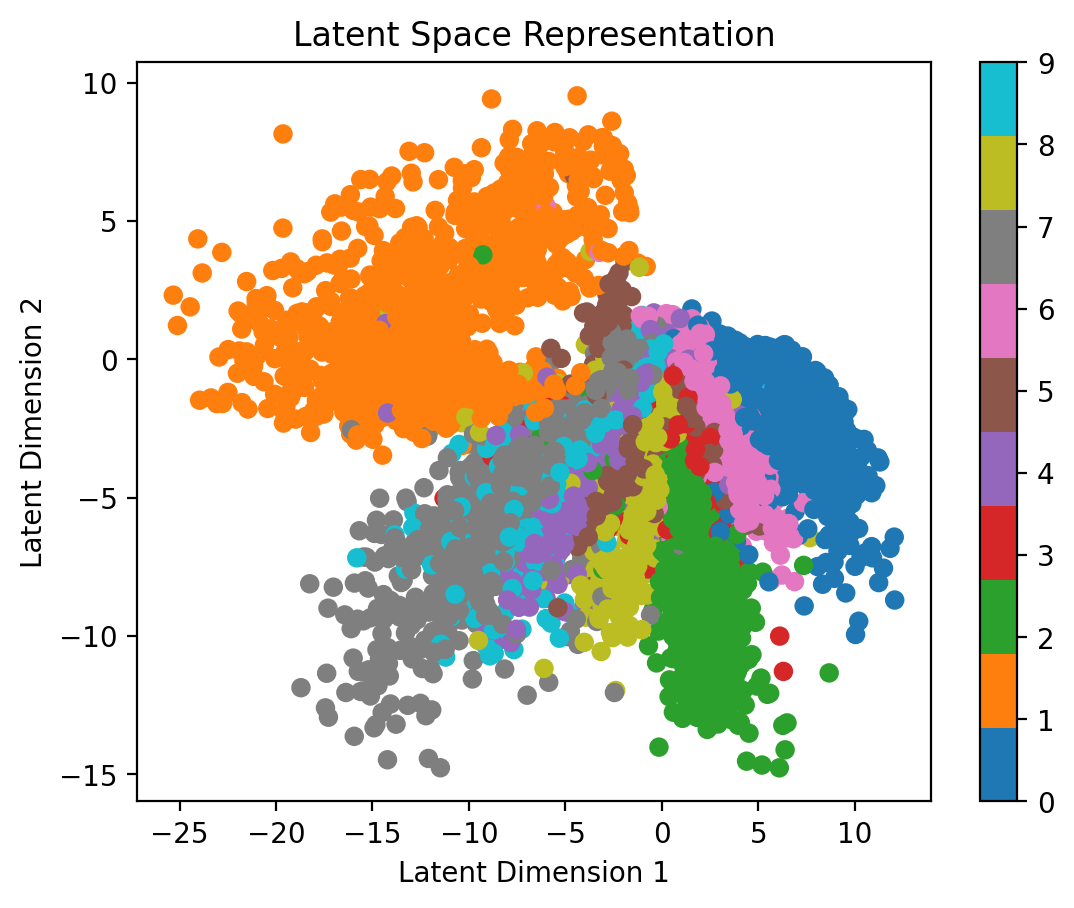

In [46]:
plot_latent(autoencoder, data)

Les vecteurs latents résultants regroupent des chiffres similaires ensemble. Nous pouvons également échantillonner uniformément dans l'espace latent et observer comment le décodeur reconstruit les entrées à partir de vecteurs latents arbitraires.

In [18]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    """
    Visualizes a grid of images reconstructed from sampled points in the latent space.

    Args:
        autoencoder (nn.Module): The trained autoencoder model, which includes a decoder.
        r0 (tuple): Range for the first dimension of the latent space to sample from.
        r1 (tuple): Range for the second dimension of the latent space to sample from.
        n (int): Number of images per row and column in the output grid.

    Description:
        - The function samples points evenly spaced within the provided ranges r0 and r1.
        - Each sampled point in the latent space is decoded into an image.
        - The resulting images are arranged in a grid, demonstrating how varying positions in the latent space
          affect the reconstructed outputs.
    """
    w = 28  # Width and height of each image (assuming square images)
    img = np.zeros((n * w, n * w))  # Initialize a blank grid for placing the reconstructed images

    # Generate points in the latent space and decode them into images
    for i, lat_y in enumerate(np.linspace(*r1, n)):
        for j, lat_x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[lat_x, lat_y]]).to(device)  # Create a latent vector
            x_hat = autoencoder.decoder(z)  # Decode the latent vector
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()  # Convert tensor to numpy array for plotting

            # Place the reconstructed image into the correct position on the grid
            img[(n - 1 - i) * w : (n - i) * w, j * w : (j + 1) * w] = x_hat

    # Display the full grid of reconstructed images
    plt.figure(figsize=(10, 10))  # Set the figure size to better view details
    plt.imshow(img, extent=[*r0, *r1])
    plt.xlabel('Latent Dimension 1')  # Label for the x-axis
    plt.ylabel('Latent Dimension 2')  # Label for the y-axis
    plt.title('Reconstructed Images from Latent Space')  # Title of the plot
    plt.show()  # Render the plot

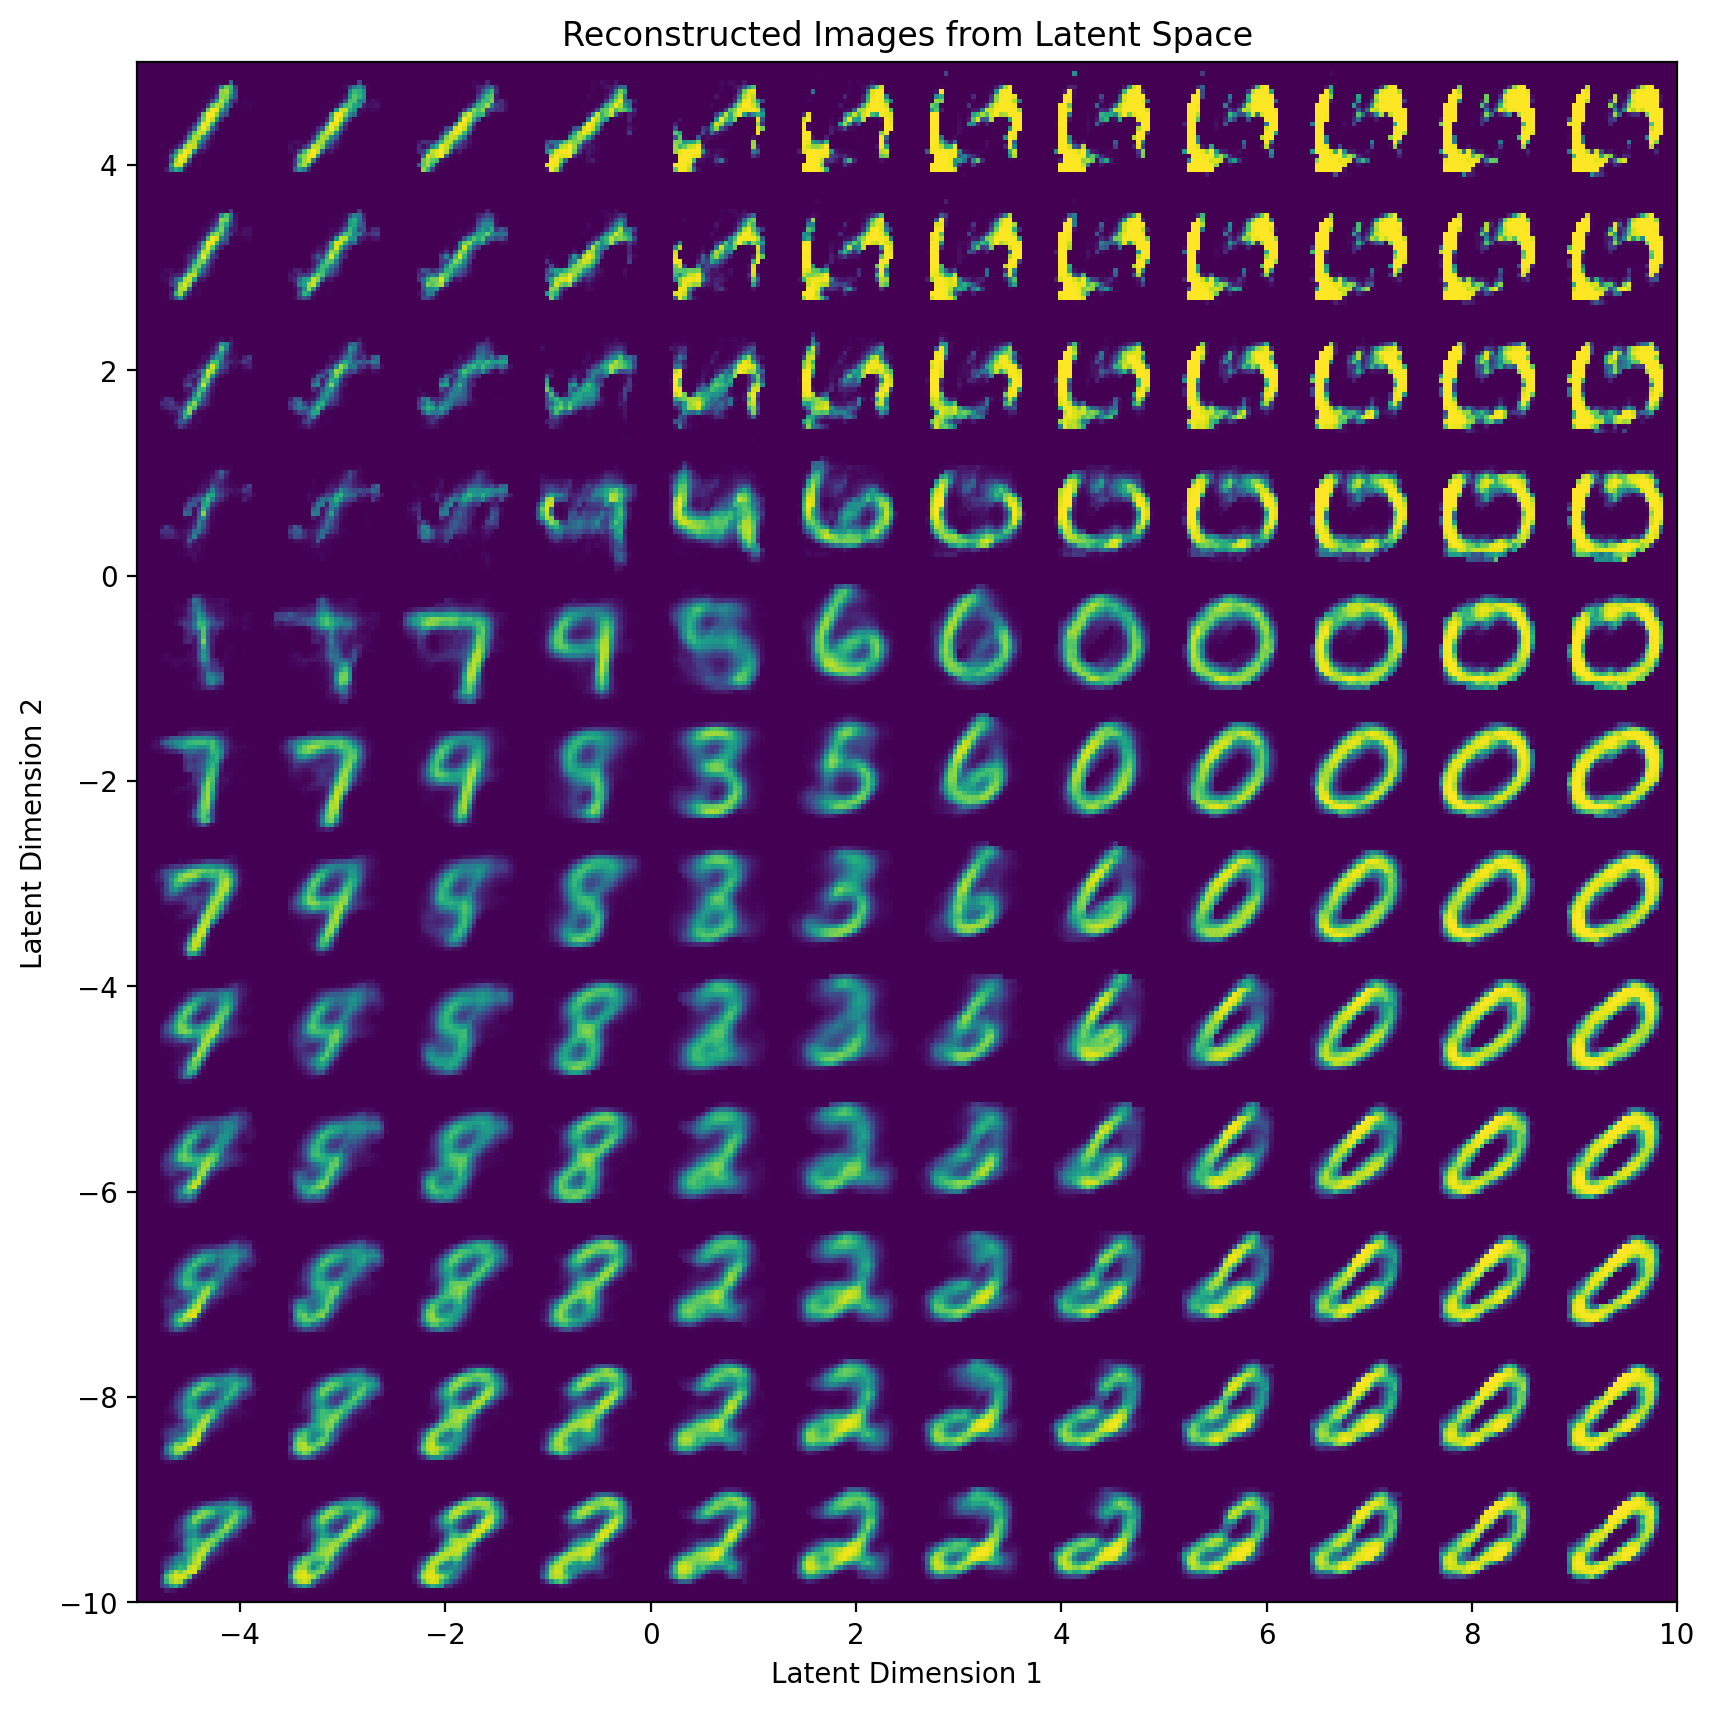

In [19]:
plot_reconstructed(autoencoder)

Nous traçons intentionnellement les vecteurs latents reconstruits en utilisant approximativement la même gamme de valeurs que celles prises par les vecteurs latents réels. Nous pouvons constater que les vecteurs latents reconstruits ressemblent à des chiffres, et le type de chiffre correspond à l'emplacement du vecteur latent dans l'espace latent.

Vous avez peut-être remarqué qu'il existe des "trous" dans l'espace latent, où aucune donnée n'est jamais mappée. Cela devient un problème lorsque nous essayons d'utiliser les autoencodeurs comme **modèles génératifs**. L'objectif des modèles génératifs est de prendre un ensemble de données $X$ et de produire davantage de points de données issus de la même distribution que celle d'où $X$ est tiré. Pour les autoencodeurs, cela signifie échantillonner des vecteurs latents $z \sim Z$ puis décoder ces vecteurs pour produire des images. Si nous échantillonnons un vecteur latent d'une région de l'espace latent qui n'a jamais été vue par le décodeur pendant l'entraînement, la sortie pourrait ne pas avoir de sens du tout. Nous observons cela dans le coin supérieur gauche de la sortie `plot_reconstructed`, qui est vide dans l'espace latent, et le chiffre décodé correspondant ne correspond à aucun chiffre existant.


# Autoencodeurs Variationnels

La seule contrainte sur la représentation du vecteur latent pour les autoencodeurs traditionnels est que les vecteurs latents doivent être facilement décodables en l'image originale. En conséquence, l'espace latent $Z$ peut devenir disjoint et non continu. Les autoencodeurs variationnels tentent de résoudre ce problème.

Dans les autoencodeurs traditionnels, les entrées sont mappées de manière déterministe à un vecteur latent $z = e(x)$. Dans les autoencodeurs variationnels, les entrées sont mappées à une distribution de probabilité sur les vecteurs latents, et un vecteur latent est ensuite échantillonné à partir de cette distribution. Le décodeur devient plus robuste dans le décodage des vecteurs latents.

Plus précisément, au lieu de mapper l'entrée $x$ à un vecteur latent $z = e(x)$, nous la mappions à un vecteur moyen $\mu(x)$ et à un vecteur d'écarts types $\sigma(x)$. Ceux-ci paramètrent une distribution gaussienne diagonale $\mathcal{N}(\mu, \sigma)$, à partir de laquelle nous échantillonnons ensuite un vecteur latent $z \sim \mathcal{N}(\mu, \sigma)$.

Cela est généralement accompli en remplaçant la dernière couche d'un autoencodeur traditionnel par deux couches, chacune produisant $\mu(x)$ et $\sigma(x)$. Une activation exponentielle est souvent ajoutée à $\sigma(x)$ pour garantir que le résultat soit positif.


<div style="text-align: center;">
    <img src="./assets/variational-autoencoder.png" alt="variational-autoencoder">
</div>

Cependant, cela ne résout pas complètement le problème. Il peut encore y avoir des lacunes dans l'espace latent parce que les moyennes produites peuvent être significativement différentes et les écarts types peuvent être petits. Pour réduire cela, nous ajoutons une **perte auxiliaire** qui pénalise la distribution $p(z \mid x)$ pour être trop éloignée de la distribution normale standard $\mathcal{N}(0, 1)$. Ce terme de pénalité est la divergence KL entre $p(z \mid x)$ et $\mathcal{N}(0, 1)$, qui est donnée par
$$
\mathbb{KL}\left( \mathcal{N}(\mu, \sigma) \parallel \mathcal{N}(0, 1) \right) = \sum_{x \in X} \left( \sigma^2 + \mu^2 - \log \sigma - \frac{1}{2} \right)
$$

Pour mettre cela en œuvre, nous n'avons pas besoin de modifier la classe `Decoder`. Nous devons uniquement changer la classe `Encoder` pour produire $\mu(x)$ et $\sigma(x)$, et ensuite utiliser ces derniers pour échantillonner un vecteur latent. Nous utilisons également cette classe pour suivre le terme de perte de divergence KL.

In [26]:
class VariationalEncoder(nn.Module):
    """
    Encoder module for a Variational Autoencoder that outputs parameters of a Gaussian distribution.

    This module provides the mean (mu) and log variance (log sigma) of the Gaussian distribution,
    which are used to sample the latent vector via the reparameterization trick.

    Attributes:
        linear1 (nn.Linear): First linear layer maps input to a hidden layer.
        linear2 (nn.Linear): Second linear layer to produce means (mu) of the latent Gaussian distribution.
        linear3 (nn.Linear): Third linear layer to produce log variances of the latent Gaussian distribution.
        N (distributions.Normal): Normal distribution used to sample epsilon for the reparameterization trick.
        kl (float): Kullback-Leibler divergence computed during the forward pass.
    """
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)  # Assumes input size typical for MNIST (28x28)
        self.linear2 = nn.Linear(512, latent_dims)  # Produces mu
        self.linear3 = nn.Linear(512, latent_dims)  # Produces log sigma

        # Define a standard normal distribution for the reparameterization trick
        self.N = distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() if device=='cuda' else self.N.loc   # Moves mean to GPU if available
        self.N.scale = self.N.scale.cuda() if device=='cuda' else self.N.scale # Mo
        self.kl = 0  # Initialize KL divergence

    def forward(self, x):
        """
        Forward pass of the variational encoder.

        Args:
            x (torch.Tensor): Input data.

        Returns:
            torch.Tensor: Sampled latent vector z from the Gaussian distribution parameterized by mu and sigma.
        """
        x = torch.flatten(x, start_dim=1)  # Flatten the image to a vector
        x = F.relu(self.linear1(x))  # Activation function after the first linear transformation
        mu = self.linear2(x)  # Linear layer to compute means
        log_sigma = self.linear3(x)  # Linear layer to compute log variances
        sigma = torch.exp(log_sigma)  # Exponentiate to get the standard deviations
        z = mu + sigma * self.N.sample(mu.shape)  # Sample using the reparameterization trick
        # Compute the KL divergence as part of the loss
        self.kl = (sigma**2 + mu**2 - log_sigma - 0.5).sum()  # Adjustment for the correct KL formula
        return z

La classe autoencodeur modifie une seule ligne de code, en remplaçant un `Encoder` par un `VariationalEncoder`.

In [27]:
class VariationalAutoencoder(nn.Module):
    """
    A Variational Autoencoder (VAE) with separate encoder and decoder modules.
    
    Args:
        latent_dims (int): The number of dimensions in the latent space.

    Attributes:
        encoder (VariationalEncoder): The encoder module that maps inputs to the latent space.
        decoder (Decoder): The decoder module that maps latent representations back to the input space.
    """
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)  # Initializes the encoder
        self.decoder = Decoder(latent_dims)  # Initializes the decoder

    def forward(self, x):
        """
        Defines the forward pass of the VAE.

        Args:
            x (Tensor): Input tensor to be processed.

        Returns:
            Tensor: The reconstructed output from the decoder.
        """
        z = self.encoder(x)  # Encodes the input to a latent representation
        return self.decoder(z)  # Decodes the latent representation back to input space


Pour entraîner l'autoencodeur variationnel, nous devons simplement ajouter la perte auxiliaire à notre algorithme d'entraînement.

Le code suivant est essentiellement copié-collé de la section précédente, avec un seul terme ajouté à la perte (`autoencoder.encoder.kl`).

In [28]:
def train(autoencoder, data, epochs=20):
    """
    Training function for the autoencoder.

    Args:
        autoencoder (Autoencoder): The autoencoder model to train.
        data (DataLoader): DataLoader providing the training data.
        epochs (int): Number of epochs to train for.
        The training is the same except the loss where we add kl loss function

    Returns:
        Autoencoder: Trained autoencoder model.
    """
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, _ in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()  + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [29]:
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae = train(vae, data)

Visualisons les représentations de vecteurs latents de quelques lots de données.

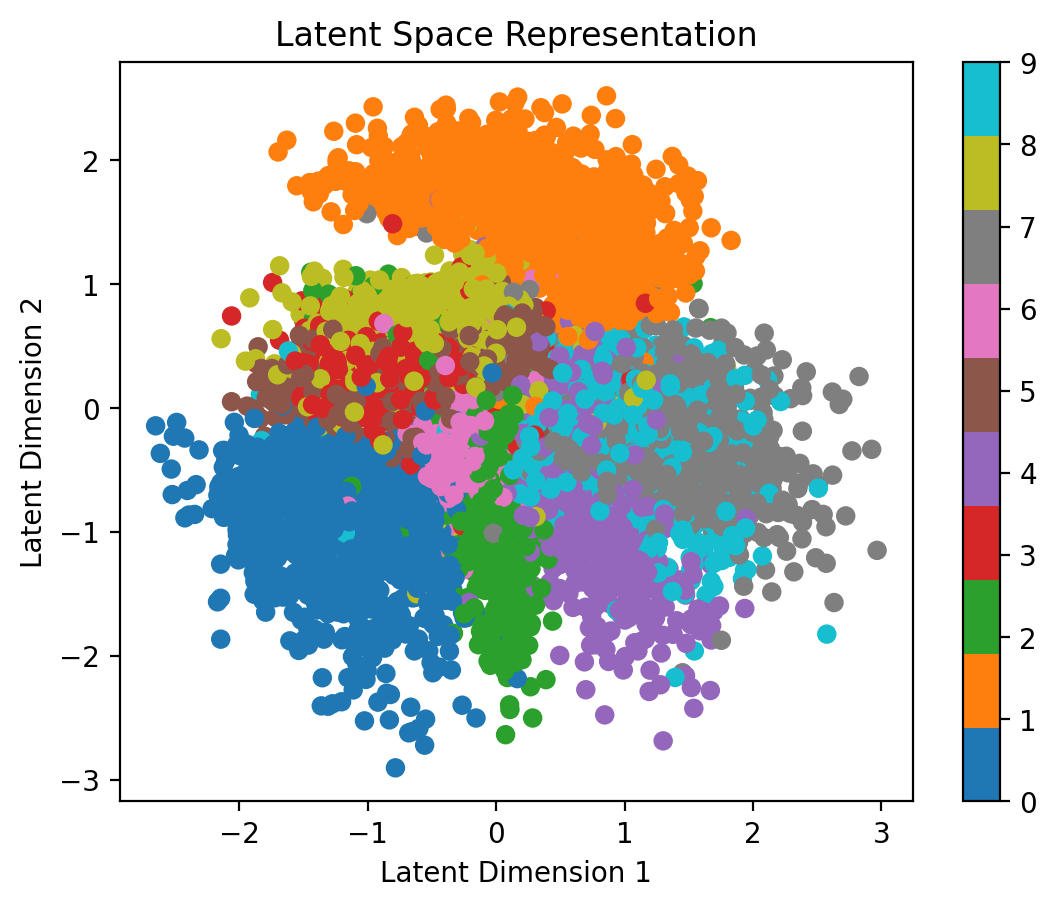

In [30]:
plot_latent(vae, data)

Nous pouvons observer que, par rapport à l'autoencodeur traditionnel, la gamme de valeurs pour les vecteurs latents est beaucoup plus petite et plus centralisée. La distribution globale de $p(z \mid x)$ semble être beaucoup plus proche d'une distribution gaussienne.

Examinons également les chiffres reconstruits à partir de l'espace latent :

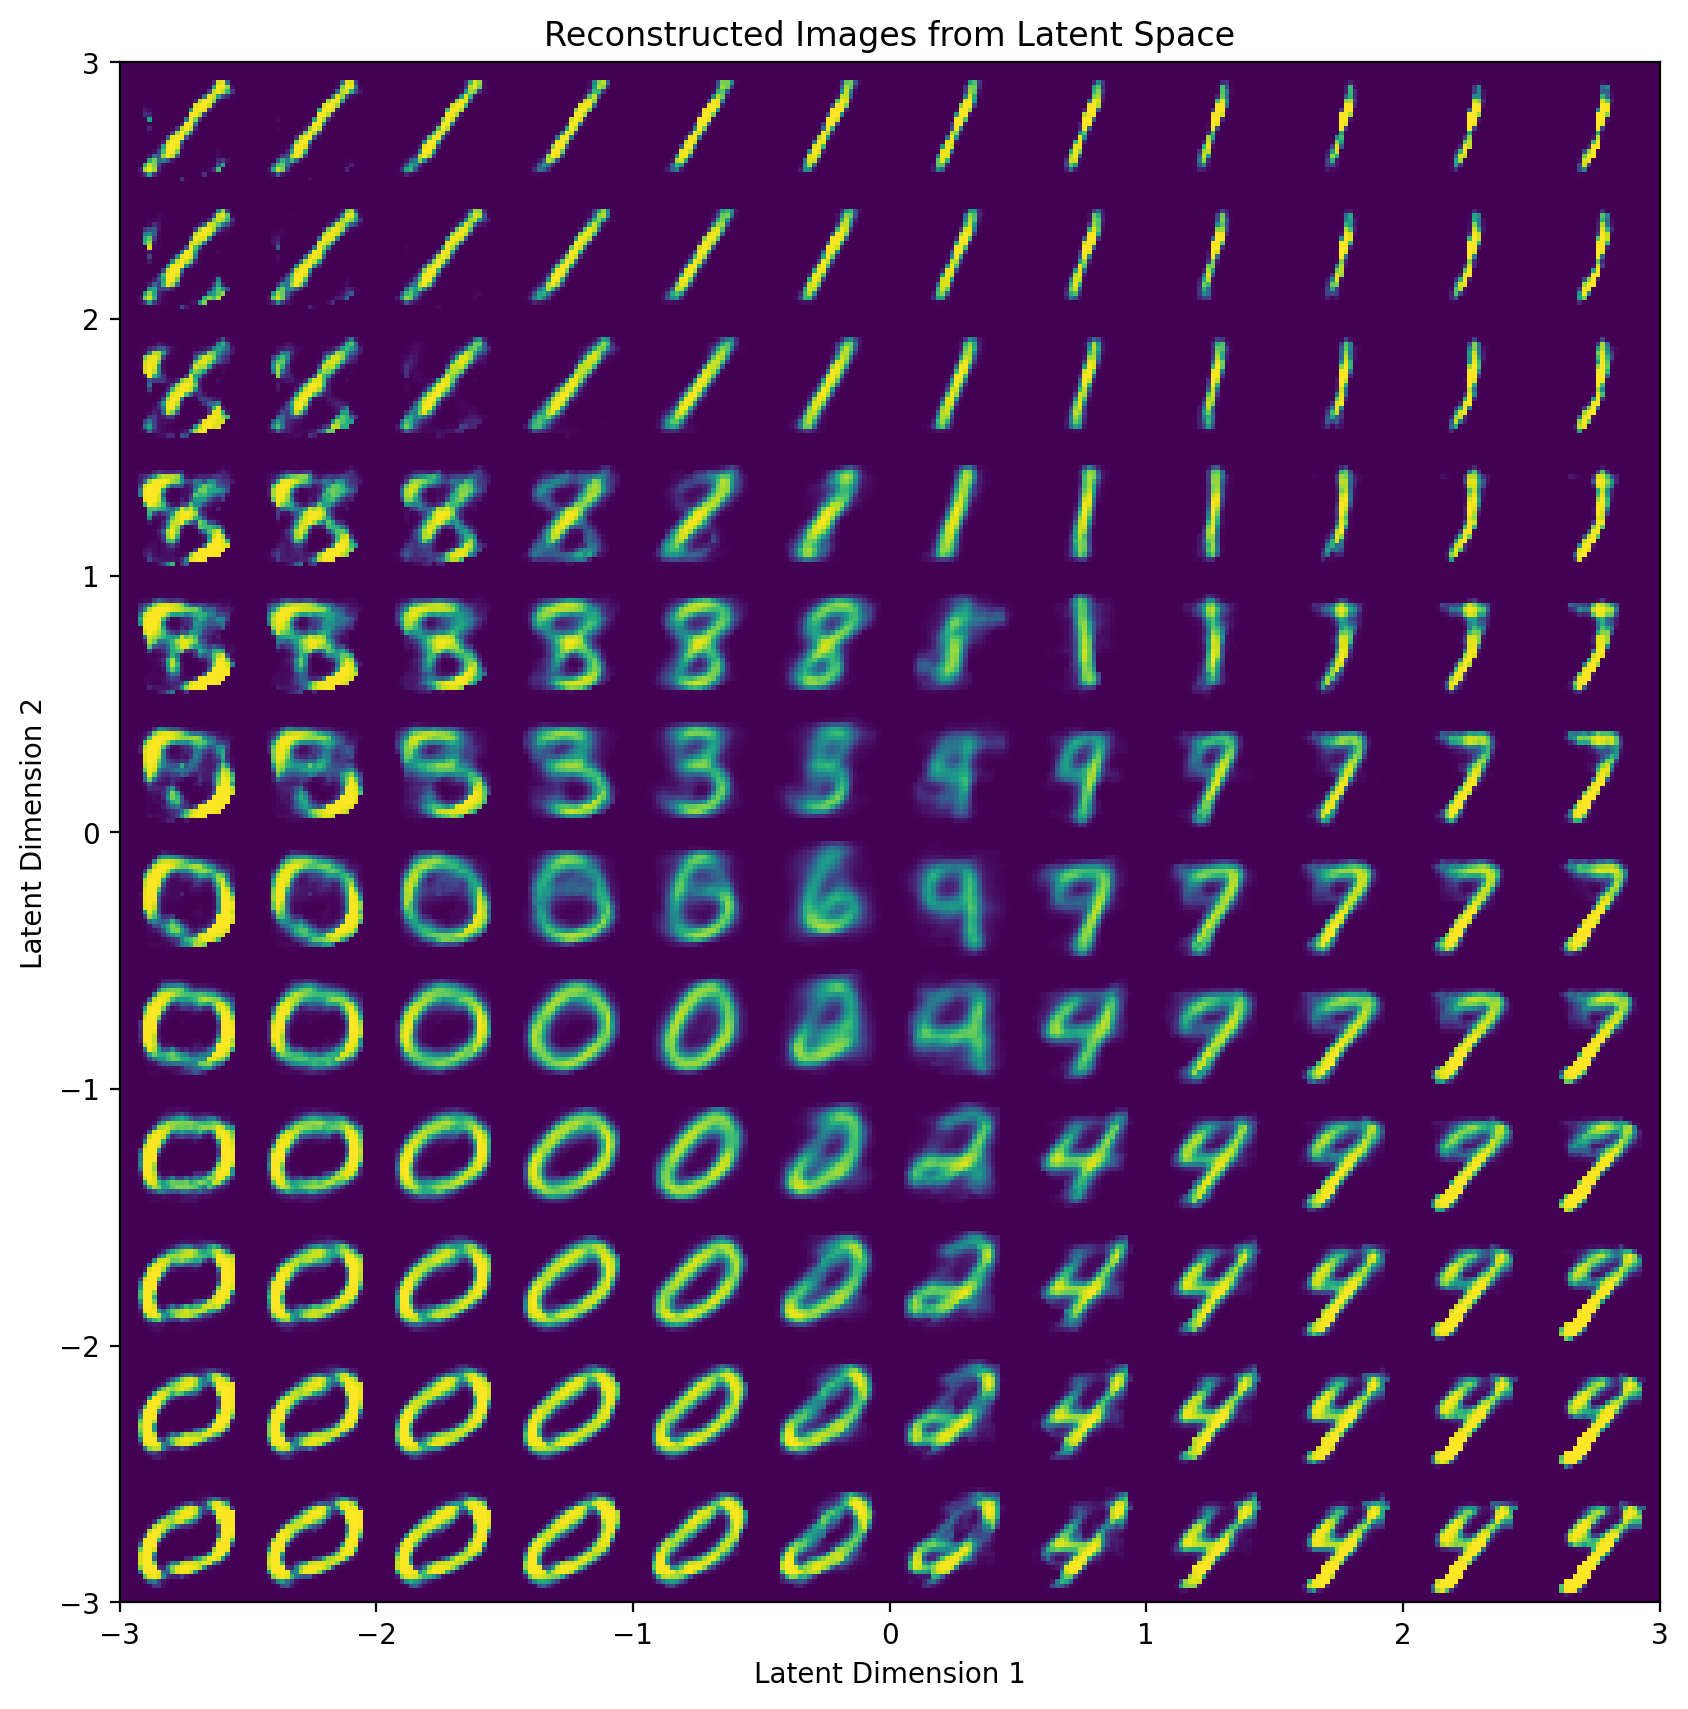

In [31]:
plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))

# Conclusions

Les autoencodeurs variationnels produisent un espace latent $Z$ qui est plus compact et plus lisse que celui appris par les autoencodeurs traditionnels. Cela nous permet d'échantillonner aléatoirement des points $z \sim Z$ et de produire des reconstructions correspondantes $\hat{x} = d(z)$ qui forment des chiffres réalistes, contrairement aux autoencodeurs traditionnels.

# Extra Fun

Une dernière chose que je voulais essayer était l'**interpolation**. Étant donné deux entrées $x_1$ et $x_2$, et leurs vecteurs latents correspondants $z_1$ et $z_2$, nous pouvons interpoler entre eux en décodant les vecteurs latents entre $x_1$ et $x_2$.

Le code suivant produit une rangée d'images montrant l'interpolation entre les chiffres.

In [35]:
def interpolate(autoencoder, x_1, x_2, n=12):
    """
    Interpolates between two images and visualizes the transition.

    Args:
        autoencoder (nn.Module): A trained autoencoder model which includes an encoder and a decoder.
        x_1 (torch.Tensor): First input tensor (image).
        x_2 (torch.Tensor): Second input tensor (image).
        n (int): Number of interpolation steps between the two images.

    Description:
        The function encodes two images into the latent space, then linearly interpolates between
        these two latent representations. It decodes each point in the latent space back to image space
        and arranges the output images in a row to show the transition.
    """
    # Encode the images into latent vectors
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    
    # Create a series of latent vectors by interpolating between z_1 and z_2
    z = torch.stack([z_1 + (z_2 - z_1) * t for t in np.linspace(0, 1, n)])
    
    # Decode the interpolated latent vectors
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()  # Move to CPU for visualization

    w = 28  # Width of each image, assuming MNIST-like images
    img = np.zeros((w, n * w))  # Create an empty array to hold the full interpolation image

    # Fill the image array with each decoded image
    for i, x_hat in enumerate(interpolate_list):
        img[:, i * w:(i + 1) * w] = x_hat.reshape(28, 28)  # Reshape and place each image in the row

    # Display the resulting interpolation
    plt.figure(figsize=(n, 2))  # Set the figure size to display all images well
    plt.imshow(img)  # Use a grayscale colormap
    plt.axis('off')  # Turn off axis markers
    plt.show()


In [36]:
# Grab a batch from the DataLoader
x, y = next(iter(data))

# Find the indices of examples labeled as '1' and '0'
indices_1 = (y == 1).nonzero(as_tuple=True)[0]
indices_0 = (y == 0).nonzero(as_tuple=True)[0]

# Select a sample for each label, ensuring there are any samples available
x_1 = x[indices_1[0]].to(device) if len(indices_1) > 0 else None
x_2 = x[indices_0[0]].to(device) if len(indices_0) > 0 else None

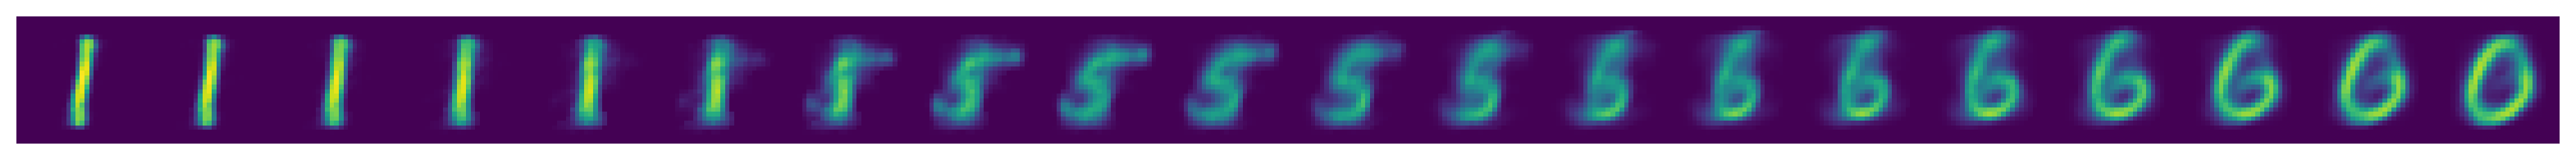

In [37]:
interpolate(vae, x_1, x_2, n=20)

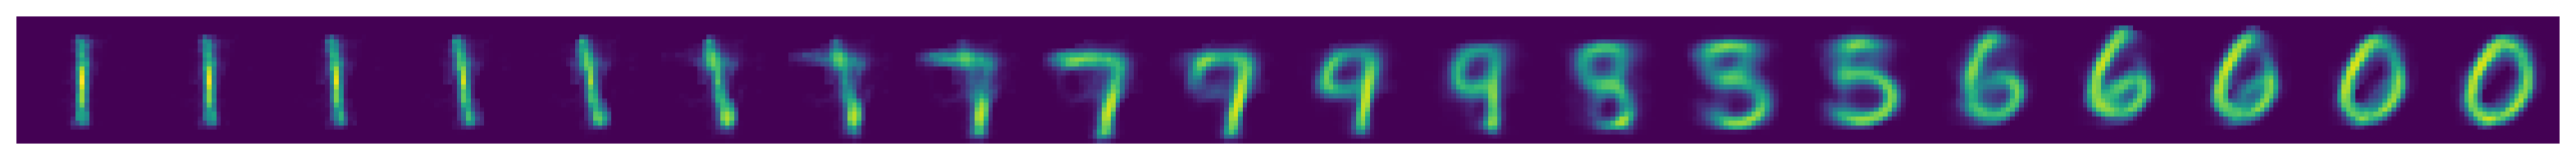

In [38]:
interpolate(autoencoder, x_1, x_2, n=20)

Je voulais également écrire du code pour générer un GIF de la transition, au lieu de simplement une rangée d'images. Le code ci-dessous modifie le code précédent pour produire un GIF.

In [39]:
def interpolate_gif(autoencoder, filename, x_1, x_2, n=100):
    """
    Generates a GIF by interpolating in the latent space between two images and decoding the results.

    Args:
        autoencoder (nn.Module): The trained autoencoder model which includes an encoder and a decoder.
        filename (str): The filename where the GIF should be saved.
        x_1 (torch.Tensor): The first input tensor (image).
        x_2 (torch.Tensor): The second input tensor (image).
        n (int): Number of interpolation steps between the two images.

    Description:
        This function encodes two images into the latent space, interpolates between these two latent
        vectors linearly, and decodes each interpolated latent vector back into image space. It then
        saves these images as frames in a GIF, effectively creating a smooth transition between the
        first image and the second image. The animation loops back to the start by reversing the frames.
    """
    # Encode the images to obtain their corresponding latent vectors
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    
    # Interpolate between the two latent vectors
    z = torch.stack([z_1 + (z_2 - z_1) * t for t in np.linspace(0, 1, n)])
    
    # Decode each interpolated latent vector into an image
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy() * 255  # Prepare for image processing
    
    # Convert tensors to image format and resize for better visibility
    images_list = [Image.fromarray(img.reshape(28, 28).astype(np.uint8)).resize((256, 256)) for img in interpolate_list]
    
    # Create a loop by appending the reverse of the image list
    images_list += images_list[::-1]  # Loop back to the beginning
    
    # Save the images as a GIF
    images_list[0].save(
        f'./assets/{filename}.gif',
        save_all=True,
        append_images=images_list[1:],
        duration=100,  # Time between frames in milliseconds
        loop=0  # Loop forever
    )

In [40]:
interpolate_gif(vae, "vae", x_1, x_2)

<img src="./assets/vae.gif">